In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import copy
#import mpld3
#import mplcursors
import geopandas

from matplotlib.colors import Normalize
from matplotlib import cm
from matplotlib import ticker
from datetime import datetime
from itertools import product
from scipy.interpolate import make_interp_spline, BSpline
from fuzzywuzzy import fuzz, process
from scipy.interpolate import make_interp_spline, BSpline

%matplotlib inline

In [2]:
# Importa dati delle regioni da Protezione Civile

df_dati_regioni = pd.read_csv('https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv',
                            parse_dates=['data'])

df_dati_regioni['data'] = df_dati_regioni['data'].dt.date

regioni = df_dati_regioni['denominazione_regione'].unique().tolist()

df_dati_regioni.set_index(['data','denominazione_regione'], inplace=True)

## Ultimi dati aggiunti

In [3]:
# Visualizza ultimi dati
df_dati_odierni = pd.read_csv('https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni-latest.csv',
                            parse_dates=['data'])
df_dati_odierni['data'] = df_dati_odierni['data'].dt.date
df_dati_odierni.set_index(['data','denominazione_regione'], inplace=True)
df_dati_odierni

stato  codice_regione        lat       long  \
data       denominazione_regione                                               
2020-04-03 Abruzzo                 ITA              13  42.351222  13.398438   
           Basilicata              ITA              17  40.639471  15.805148   
           P.A. Bolzano            ITA               4  46.499335  11.356624   
           Calabria                ITA              18  38.905976  16.594402   
           Campania                ITA              15  40.839566  14.250850   
           Emilia-Romagna          ITA               8  44.494367  11.341721   
           Friuli Venezia Giulia   ITA               6  45.649435  13.768136   
           Lazio                   ITA              12  41.892770  12.483667   
           Liguria                 ITA               7  44.411493   8.932699   
           Lombardia               ITA               3  45.466794   9.190347   
           Marche                  ITA              11  43.616760  13.518875   
           Molise                  ITA              14  41.557748  14.659161   
           Piemonte                ITA               1  45.073274   7.680687   
           Puglia                  ITA              16  41.125596  16.867367   
           Sardegna                ITA              20  39.215312   9.110616   
           Sicilia                 ITA              19  38.115697  13.362357   
           Toscana                 ITA               9  43.769231  11.255889   
           P.A. Trento             ITA               4  46.068935  11.121231   
           Umbria                  ITA              10  43.106758  12.388247   
           Valle d'Aosta           ITA               2  45.737503   7.320149   
           Veneto                  ITA               5  45.434905  12.338452   

                                  ricoverati_con_sintomi  terapia_intensiva  \
data       denominazione_regione                                              
2020-04-03 Abruzzo                                   361                 76   
           Basilicata                                 41                 19   
           P.A. Bolzano                              291                 60   
           Calabria                                  183                 17   
           Campania                                  532                115   
           Emilia-Romagna                           3915                364   
           Friuli Venezia Giulia                     201                 61   
           Lazio                                    1194                188   
           Liguria                                  1147                173   
           Lombardia                               11802               1381   
           Marche                                    982                158   
           Molise                                     31                  8   
           Piemonte                                 3300                452   
           Puglia                                    648                123   
           Sardegna                                  122                 24   
           Sicilia                                   535                 73   
           Toscana                                  1149                288   
           P.A. Trento                               343                 80   
           Umbria                                    165                 48   
           Valle d'Aosta                              85                 25   
           Veneto                                   1714                335   

                                  totale_ospedalizzati  \
data       denominazione_regione                         
2020-04-03 Abruzzo                                 437   
           Basilicata                               60   
           P.A. Bolzano                            351   
           Calabria                                200   
           Campania       

## Il trend giorno per giorno
Casi attualmente positivi, guariti, morti e casi totali dal primo rilevamento a oggi. Dati totali e casi nuovi giorno per giorno.

In [4]:
# Preparo i dati per il trend giornaliero selezionando le colonne interessate

columns = ['totale_positivi','dimessi_guariti','deceduti','totale_casi','tamponi']

df_dati_regioni_totali = df_dati_regioni.groupby(level='data').sum()
df_dati_regioni_totali = df_dati_regioni_totali[columns]

df_dati_regioni_totali_giornalieri = df_dati_regioni_totali[columns].copy()

for column in columns:
    df_dati_regioni_totali_giornalieri[column] = df_dati_regioni_totali_giornalieri[column] - df_dati_regioni_totali_giornalieri[column].shift(1)

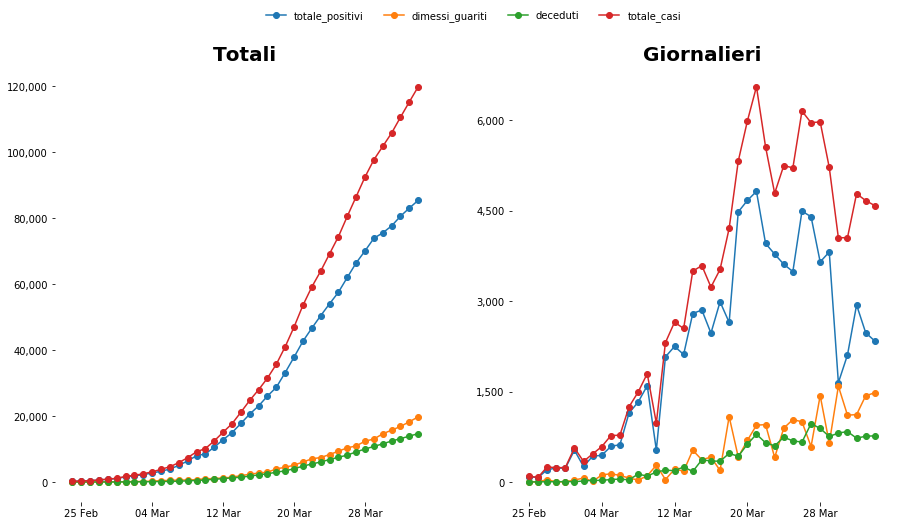

In [5]:
# Plot grafiche trend giornaliero
columns = ['totale_positivi','dimessi_guariti','deceduti','totale_casi']

fig, axs = plt.subplots(1, 2, figsize=(15, 8), sharey=False)

for column in columns:
    axs[0].plot(df_dati_regioni_totali[column],marker="o", label=column)
    axs[1].plot(df_dati_regioni_totali_giornalieri[column],marker="o", label=column)

for i in (0,1):
    axs[i].xaxis.set_major_locator(plt.MaxNLocator(6))
    axs[i].yaxis.set_major_locator(plt.MaxNLocator(7))
    axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
    axs[i].get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    axs[i].set_frame_on(False)
    
axs[0].legend(ncol=4,loc='upper center',bbox_to_anchor=(1.1, 1.15),edgecolor='white')
axs[0].set_title('Totali',fontsize=20,fontweight="bold")
axs[1].set_title('Giornalieri',fontsize=20,fontweight="bold")

plt.show()

## La variazione percentuale giornaliera
Come varia la crescita in termini percentuali dei casi totali giorno per giorno.

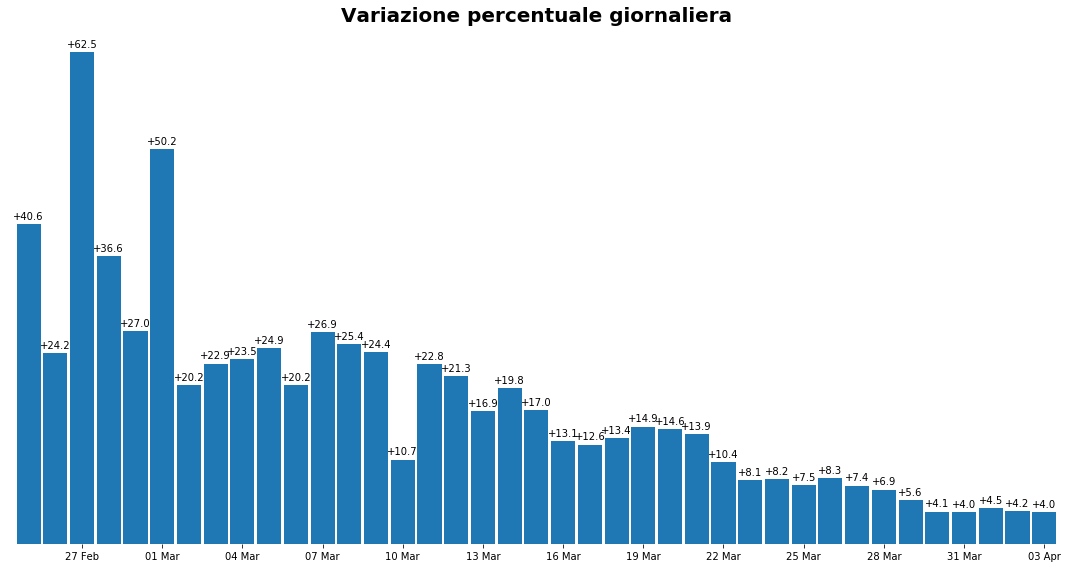

In [6]:
df_variazione_percentuale = (df_dati_regioni_totali_giornalieri['totale_casi']/
                             df_dati_regioni_totali['totale_casi'].shift(1))*100
df_variazione_percentuale.dropna(inplace=True)
x = mdates.date2num(df_variazione_percentuale.index)
w = 0.8

fig, ax = plt.subplots(figsize=(15,8))

bars = ax.bar(x, df_variazione_percentuale.round(1), width=0.9)

ax.set_title('Variazione percentuale giornaliera',fontsize=20,fontweight="bold")
ax.set_xlim(x.min()-w, x.max()+w)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
ax.yaxis.set_visible(False)
ax.set_frame_on(False)

def autolabel(bars):
    """Aggiunge la percentuale sopra ogni barra """
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{:+.1f}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
autolabel(bars)

fig.tight_layout()
plt.show()

## Tamponi giornalieri e contagiati

Il numero di nuovi contagiati giorno per giorno, il numero di test giornalieri e il loro rapporto percentuale.

In [7]:
df_dati_regioni_totali_giornalieri.tail()

,totale_positivi,dimessi_guariti,deceduti,totale_casi,tamponi
data,,,,,
2020-03-30,1648.0,1590.0,812.0,4050.0,23329.0
2020-03-31,2107.0,1109.0,837.0,4053.0,29609.0
2020-04-01,2937.0,1118.0,727.0,4782.0,34455.0
2020-04-02,2477.0,1431.0,760.0,4668.0,39809.0
2020-04-03,2339.0,1480.0,766.0,4585.0,38617.0


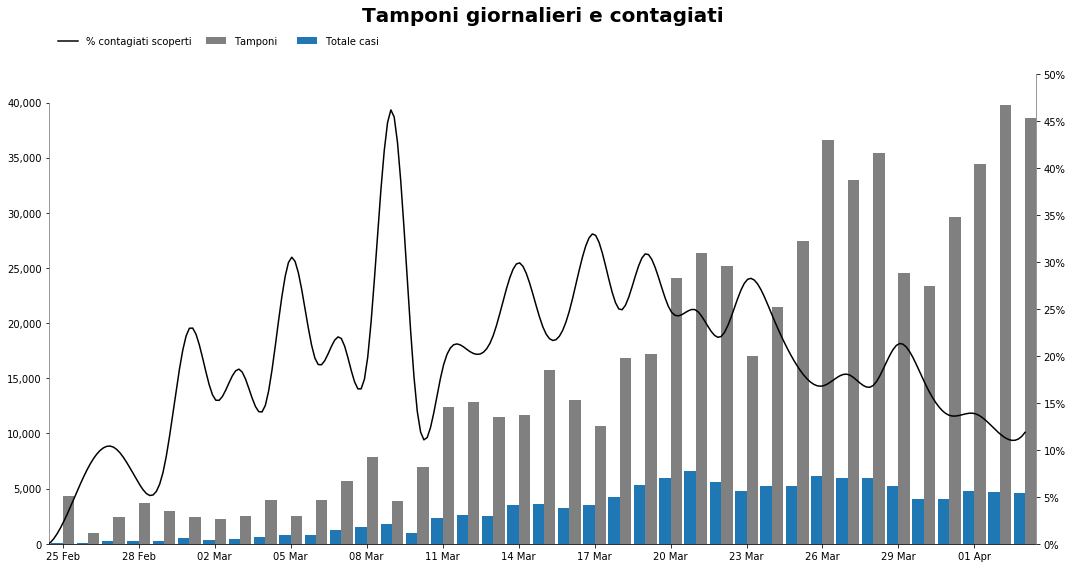

In [8]:
df_tamponi_contagiati = df_dati_regioni_totali_giornalieri.copy()
df_tamponi_contagiati['percentuale_contagiati_scoperti'] = (df_tamponi_contagiati['totale_casi']
                                                            /df_tamponi_contagiati['tamponi'])*100
df_tamponi_contagiati.fillna(0,limit=1,inplace=True)

width = 0.45
x = mdates.date2num(df_tamponi_contagiati.index)

ymax = df_tamponi_contagiati['tamponi'].max()+5000.

# Preparare la grafica di percentuali per renderla più liscia
xnew = np.linspace(x.min(),x.max(),300)
percentuali = df_tamponi_contagiati['percentuale_contagiati_scoperti']
spl = make_interp_spline(x, percentuali, k=3)
percentuali_smooth = spl(xnew)

# Plot
fig, ax1 = plt.subplots(figsize=(15,8))

bars1 = ax1.bar(x + width/2,df_tamponi_contagiati['tamponi'],width,label='Tamponi',color='grey')
bars2 = ax1.bar(x - width/2,df_tamponi_contagiati['totale_casi'],width,label='Totale casi')

ax1.set_title('Tamponi giornalieri e contagiati',fontsize=20,fontweight="bold")

ax1.set_xlim(x.min()+width,x.max()+width)
ax1.set_ylim(0,ymax+2000.)

(ytick1_min, ytick1_max) = (ax1.get_yticks()[0], ax1.get_yticks()[-1])
newyticks1 = np.arange(ytick1_min, ytick1_max, step=5000.)

ax1.set_yticks(newyticks1)
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

# Convertire l'asse da numero a data
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=3))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))

ax1.legend(ncol=2,loc='upper left',bbox_to_anchor=(0.15, 1),frameon=False)
ax1.spines['left'].set_color('grey')
ax1.spines['right'].set_color('none')
ax1.spines['top'].set_color('none')
ax1.spines['left'].set_smart_bounds(True)

# Creare nuove assi per rappresentare le percentuali
ax2 = ax1.twinx()
perc = ax2.plot(xnew,percentuali_smooth,color='k',label='% contagiati scoperti')
ax2.set_ylim(0,percentuali_smooth.max()+5)

(ytick2_min, ytick2_max) = (ax2.get_yticks()[0], ax2.get_yticks()[-1])
newyticks2 = np.arange(ytick2_min, ytick2_max, step=5.)

ax2.tick_params(axis='y')
ax2.set_yticks(newyticks2)
ax2.yaxis.set_major_formatter(ticker.FormatStrFormatter('%d%%'))
ax2.legend(loc='upper left',edgecolor='w')

ax2.spines['right'].set_color('grey')
ax2.spines['left'].set_color('none')
ax2.spines['top'].set_color('none')
ax2.spines['bottom'].set_color('none')
ax2.spines['right'].set_smart_bounds(True)


fig.tight_layout() 
plt.show()

## L’andamento delle 5 regioni con più contagi
Il numero di casi totali nelle 5 regioni dove il coronavirus è più diffuso. 

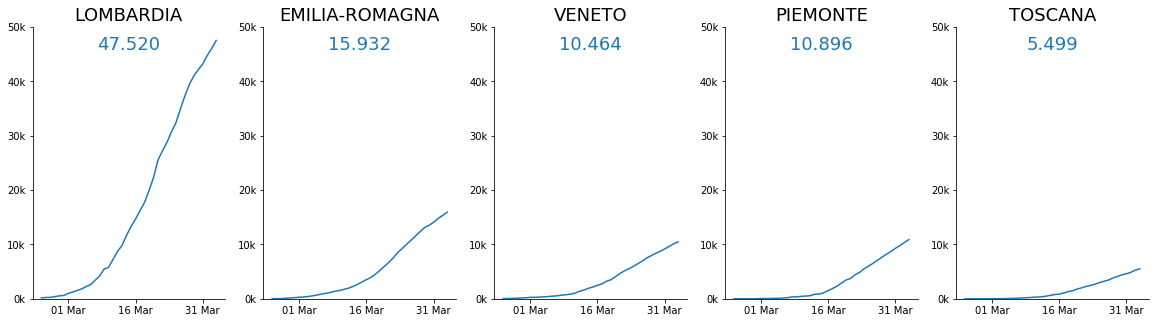

In [9]:
n = 5

df_top_regioni = df_dati_regioni.groupby(level='denominazione_regione').sum()
top_n = df_top_regioni.nlargest(n, 'totale_casi').index.tolist()

df_dati_andamento_regioni = df_dati_regioni['totale_casi'].copy()

fig, axs = plt.subplots(1,5,figsize=(20,5),sharey=True)

subplots = [0,1,2,3,4]
for s,regione in zip(subplots,top_n):
    maxval = df_dati_andamento_regioni.xs(regione, level='denominazione_regione').max()
    maxvaltext = '{:.3f}'.format(maxval/1000)
    
    axs[s].plot(df_dati_andamento_regioni.xs(regione, level='denominazione_regione'),label=maxval)
    axs[s].set_title('{}'.format(regione.upper()),fontsize=18)
    axs[s].set_ylim(bottom=0,top=50000)
    axs[s].xaxis.set_major_locator(plt.MaxNLocator(3))
    axs[s].xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
    axs[s].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(str(int(x/1000))+'k')))
    axs[s].spines['right'].set_visible(False)
    axs[s].spines['top'].set_visible(False)
    axs[s].yaxis.set_ticks_position('left')
    
    leg = axs[s].legend(loc='upper center',title=maxvaltext,frameon=False)
    plt.setp(leg.get_texts(), color='w')
    plt.setp(leg.get_title(),fontsize=18,color='#1f77b4')
    for item in leg.legendHandles:
        item.set_visible(False)
        
plt.show()

## Il trend di terapie intensive e ricoveri
Il numero di ricoveri giornalieri, quelli in terapia intensiva, le persone in isolamento domiciliare e la crescita percentuale giornaliera. Sfogliando sulla destra, il rapporto percentuale tra le singole voci. 

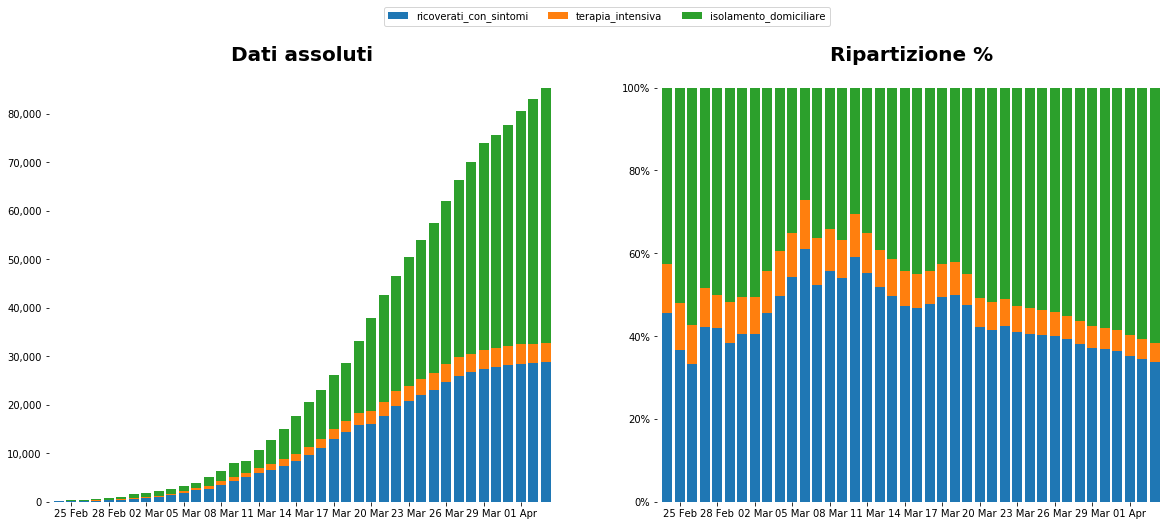

In [10]:
columns = ['ricoverati_con_sintomi','terapia_intensiva','isolamento_domiciliare','totale_positivi']
df_terapia = df_dati_regioni[columns].copy()

# Ragruppo i dati per data
df_terapia = df_terapia.groupby(level='data').sum()

# Creo i dati con le percentuali
df_terapia_perc = df_terapia.copy()
df_terapia_perc['ricoverati_con_sintomi'] = (df_terapia_perc['ricoverati_con_sintomi']/df_terapia_perc['totale_positivi'])*100
df_terapia_perc['terapia_intensiva'] = (df_terapia_perc['terapia_intensiva']/df_terapia_perc['totale_positivi'])*100
df_terapia_perc['isolamento_domiciliare'] = (df_terapia_perc['isolamento_domiciliare']/df_terapia_perc['totale_positivi'])*100

# Preparo stampa grafico
x = mdates.date2num(df_terapia.index)
w = 0.8

fig, axs = plt.subplots(1,2,figsize=(20,8),sharey=False)

axs[0].bar(x,df_terapia[columns[0]],label=columns[0])
axs[0].bar(x,df_terapia[columns[1]],label=columns[1], bottom=df_terapia[columns[0]])
axs[0].bar(x,df_terapia[columns[2]],label=columns[2], bottom=df_terapia[columns[0]]+df_terapia[columns[1]])
axs[0].legend(ncol=3,loc='upper center',bbox_to_anchor=(1.1, 1.15))
axs[0].set_title('Dati assoluti',fontsize=20,fontweight="bold")

axs[1].bar(x,df_terapia_perc[columns[0]],label=columns[0])
axs[1].bar(x,df_terapia_perc[columns[1]],label=columns[1], bottom=df_terapia_perc[columns[0]])
axs[1].bar(x,df_terapia_perc[columns[2]],label=columns[2], bottom=df_terapia_perc[columns[0]]+df_terapia_perc[columns[1]])
axs[1].set_title('Ripartizione %',fontsize=20,fontweight="bold")

# Valori comuni per entrambi subplot
for s in (0,1):
    axs[s].set_xlim(x.min()-w, x.max()+w)
    axs[s].set_frame_on(False)
    axs[s].xaxis.set_major_locator(mdates.DayLocator(interval=3))
    axs[s].xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))

# Formatto l'asse y
axs[0].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
axs[1].yaxis.set_major_formatter(ticker.FormatStrFormatter('%d%%'))


plt.show()

## L’andamento nelle province con più contagi
Il numero di casi totali nelle dieci province dove il coronavirus è più diffuso. 

In [11]:
# Preparo i dati delle province
df_dati_province = pd.read_csv('https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-province/dpc-covid19-ita-province.csv',
                            parse_dates=['data'])

df_dati_province['data'] = df_dati_province['data'].dt.date

# Filtro i dati con 'In fase di definizione/aggiornamento'
filtro = df_dati_province['denominazione_provincia'] != 'In fase di definizione/aggiornamento'
df_dati_province = df_dati_province[filtro]
province = df_dati_province['denominazione_provincia'].unique().tolist()

# Set index
df_dati_province.set_index(['data','denominazione_regione','denominazione_provincia'], inplace=True)

# Cerco le top N provincie nell'ultimo giorno
n = 10
last_day = df_dati_province.index.get_level_values(0)[-1]

#df_top_province = df_dati_province.groupby(level='denominazione_provincia').sum()
df_top_province = df_dati_province.loc[last_day].groupby(level='denominazione_provincia').sum()
top_n = df_top_province.nlargest(n, 'totale_casi').index.tolist()
print(top_n)

['Milano', 'Bergamo', 'Brescia', 'Torino', 'Cremona', 'Piacenza', "Reggio nell'Emilia", 'Monza e della Brianza', 'Padova', 'Roma']


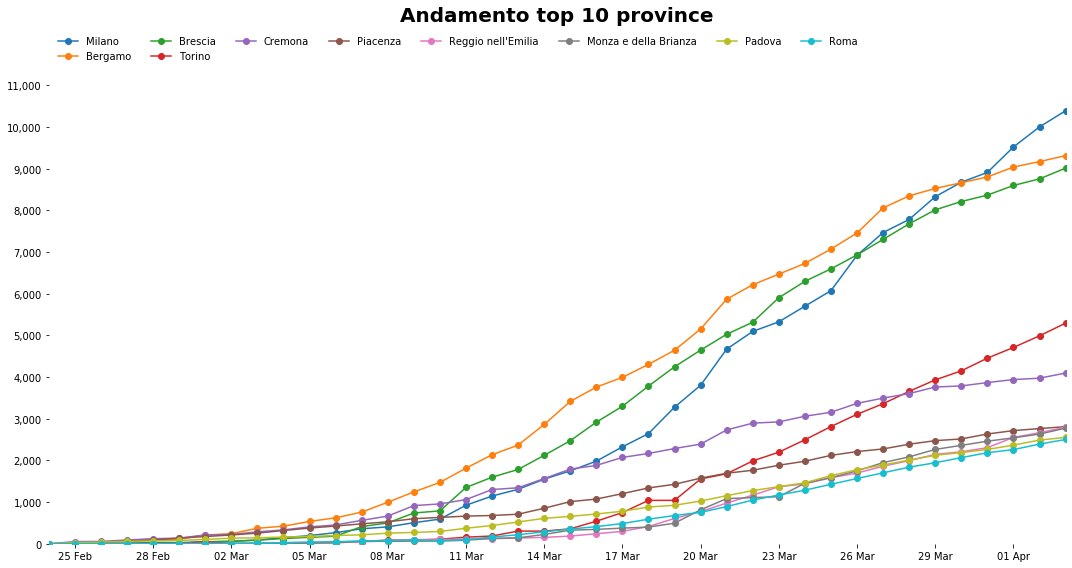

In [12]:
# Creo dataset andamento province
df_andamento_province = df_dati_province['totale_casi'].copy()
df_andamento_province = df_andamento_province.droplevel('denominazione_regione')

# Plot grafiche
x = mdates.date2num(df_andamento_province.index.get_level_values(0))
ymax = df_andamento_province.max()+1000.
yticks = np.arange(0,ymax, step=1000.)

fig, ax = plt.subplots(figsize=(15,8))

for provincia in top_n:
    ax.plot(df_andamento_province.xs(provincia,level='denominazione_provincia'),marker="o",label=provincia)

ax.set_xlim(x.min(), x.max())
ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
ax.set_ylim(0,ymax+1000.)
ax.set_yticks(yticks)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax.set_title('Andamento top {} province'.format(n),fontsize=20,fontweight="bold")
ax.legend(ncol=8,loc='upper left',frameon=False)

ax.set_frame_on(False)

fig.tight_layout() 
plt.show()

## La mappa del coronavirus in Italia
I dati dei contagi sono aggregati per provincia e i morti per regione. Per gli altri Paesi europei il dato è nazionale.

In [13]:
col = ['lat','long','totale_casi']
df_mappa = df_dati_province.loc[last_day][col]
df_mappa

lat       long  \
denominazione_regione denominazione_provincia                         
Abruzzo               Chieti                   42.351032  14.167546   
                      L'Aquila                 42.351222  13.398438   
                      Pescara                  42.464584  14.213648   
                      Teramo                   42.658918  13.704400   
Basilicata            Matera                   40.667512  16.597924   
...                                                  ...        ...   
Veneto                Rovigo                   45.071073  11.790070   
                      Treviso                  45.667546  12.245074   
                      Venezia                  45.434905  12.338452   
                      Verona                   45.438390  10.993527   
                      Vicenza                  45.547497  11.545971   

                                               totale_casi  
denominazione_regione denominazione_provincia               
Abruzzo               Chieti                           310  
                      L'Aquila                         166  
                      Pescara                          669  
                      Teramo                           418  
Basilicata            Matera                           124  
...                                                    ...  
Veneto                Rovigo                           180  
                      Treviso                         1657  
                      Venezia                         1321  
                      Verona                          2488  
                      Vicenza                         1514  

[107 rows x 3 columns]

(6.770990882083751, 18.72105578391625, 36.43626211887233, 46.98816439112767)

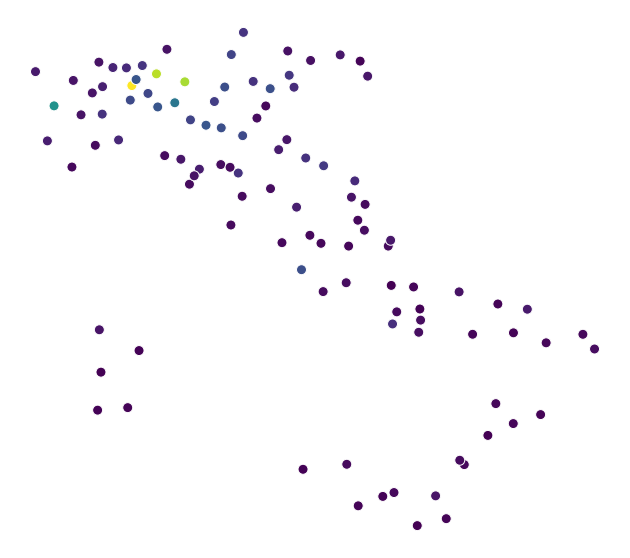

In [40]:
# url_it_prov = 'https://raw.githubusercontent.com/openpolis/geojson-italy/master/geojson/limits_IT_provinces.geojson'
url_it_reg = 'https://raw.githubusercontent.com/openpolis/geojson-italy/master/geojson/limits_IT_regions.geojson'

gdf = geopandas.GeoDataFrame(
    df_mappa, geometry=geopandas.points_from_xy(df_mappa.long, df_mappa.lat))
#italy = geopandas.read_file(url_it_reg)

ax = gdf.plot(column='totale_casi',edgecolor='w',cmap='viridis', markersize=100, figsize=(15,10))
ax.axis('off')